# Assignment #04: Uninformed Search Template - Updated Version

## Problem Description

In this assignment, you will implement four search algorithms on a tree. The tree represents a simple toy problem where each node has a value, and you aim to find a target value using the specified search techniques:

1. Breadth-First Search (BFS) - Implementation Provided;
2. Uniform-Cost Search (UCS)
3. Depth-First Search (DFS)
4. Depth-Limited Search (DLS)

### Prerequisites

Before starting, ensure you have the necessary libraries installed. You can install them using the following command:

```bash
pip install matplotlib networkx pygraphviz
```

Make sure you have Graphviz installed for `pygraphviz`. You can download it from [Graphviz.org](https://graphviz.org/).


### Tree Structure

The tree will have a maximum depth of 5, and each node will have exactly 3 children. Each node will have:

-   A unique name corresponding to a real-world application (e.g., "Email", "Browser", "Social Media").
-   A numerical cost value.
-   Child nodes as part of the tree structure.

### Example Tree Visualization

The tree will look like this:

```plaintext
                Liam 0
         /        |        \
     Olivia 1   Noah 2     Emma 3
    /  |  \     / | \     /  |  \
 .....

This example represents a hierarchy of software applications with increasing levels of specificity as the tree deepens.
```


BFS Visited Nodes: ['Liam 0', 'Olivia 1', 'Noah 2', 'Emma 3', 'Oliver 4', 'Ava 5', 'Elijah 6', 'Sophia 7', 'James 8', 'Isabella 9', 'William 10', 'Mia 11', 'Benjamin 12', 'Charlotte 13', 'Lucas 14', 'Amelia 15', 'Henry 16', 'Harper 17', 'Alexander 18', 'Evelyn 19', 'Jack 20']
BFS Path: ['Liam 0', 'Noah 2', 'James 8', 'Jack 20']

DFS Visited Nodes: ['Evelyn 19', 'Lucas 14', 'Alexander 18', 'Jack 20', 'Oliver 4', 'Charlotte 13', 'Sophia 7', 'Noah 2', 'Amelia 15', 'James 8', 'Ava 5', 'Henry 16', 'Harper 17', 'Elijah 6', 'Liam 0', 'Olivia 1']
DFS Path: ['Liam 0', 'Noah 2', 'James 8', 'Jack 20']

DLS Visited Nodes: ['Evelyn 19', 'Lucas 14', 'Alexander 18', 'Jack 20', 'Oliver 4', 'Charlotte 13', 'Sophia 7', 'Noah 2', 'Amelia 15', 'James 8', 'Ava 5', 'Henry 16', 'Harper 17', 'Elijah 6', 'Liam 0', 'Olivia 1']
DLS Path: ['Liam 0', 'Noah 2', 'James 8', 'Jack 20']

UCS Visited Nodes: ['Liam 0', 'Olivia 1', 'Noah 2', 'Oliver 4', 'Emma 3', 'Ava 5', 'Sophia 7', 'Charlotte 13', 'Elijah 6', 'James 8',

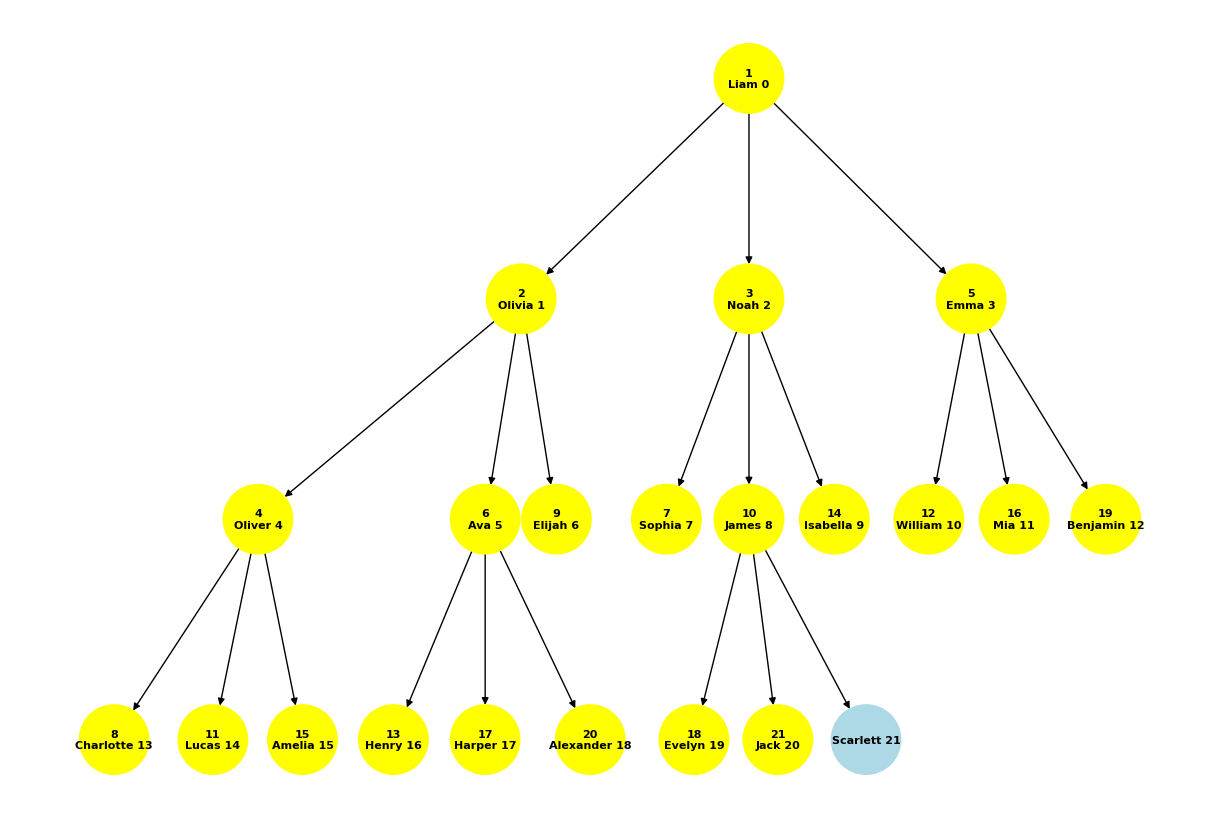

In [81]:
from heapq import heappop, heappush
from collections import deque
from copy import deepcopy
from itertools import count
import networkx as nx
import matplotlib.pyplot as plt

# List of common first names
FIRST_NAMES = [
    "Liam", "Olivia", "Noah", "Emma", "Oliver", "Ava", "Elijah", "Sophia",
    "James", "Isabella", "William", "Mia", "Benjamin", "Charlotte", "Lucas", "Amelia",
    "Henry", "Harper", "Alexander", "Evelyn", "Jack", "Scarlett"
]

###############################################
# TreeNode Class
class TreeNode:
    node_count = 0

    def __init__(self, cost):
        if TreeNode.node_count < len(FIRST_NAMES):  # Ensure only 22 nodes are created
            self.name = f"{FIRST_NAMES[TreeNode.node_count]} {TreeNode.node_count}"  # Name with number
        else:
            self.name = f"Extra {TreeNode.node_count}"  # In case more nodes are created
        self.label = self.name  # Store full label with number
        self.cost = cost
        self.children = []
        TreeNode.node_count += 1

    def add_child(self, child_node):
        if TreeNode.node_count <= len(FIRST_NAMES):  # Only allow up to 22 nodes
            self.children.append(child_node)

###############################################
# Create a tree with branching factor 3 but exactly 22 nodes
def create_fixed_tree():
    TreeNode.node_count = 0  # Reset node count
    root = TreeNode(0)
    queue = [root]
    total_nodes = 1

    node_map = {root.name: root}

    while queue and total_nodes < len(FIRST_NAMES):
        parent = queue.pop(0)
        children_to_add = min(3, len(FIRST_NAMES) - total_nodes)
        children = [TreeNode(parent.cost + i + 1) for i in range(children_to_add)]
        parent.children.extend(children)
        queue.extend(children)
        total_nodes += children_to_add

        for child in children:
            node_map[child.name] = child

    # Move Elijah 6's children to James 8 and remove them from Elijah 6
    if "Elijah 6" in node_map and "James 8" in node_map:
        james_node = node_map["James 8"]
        elijah_node = node_map["Elijah 6"]
        james_node.children.extend(elijah_node.children)
        elijah_node.children = []

    return root

###############################################
# Visualize the Tree (show visit order only, reduce font size)
def visualize_tree(root, visited_nodes=None):
    graph = nx.DiGraph()

    def add_edges(node):
        for child in node.children:
            graph.add_edge(node.label, child.label)
            add_edges(child)

    add_edges(root)

    # Use top-down hierarchical layout
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot", args="-Grankdir=TB")

    # Assign labels based on visit order only
    node_labels = {}
    node_colors = []
    for i, node in enumerate(graph.nodes):
        if visited_nodes and node in visited_nodes:
            node_colors.append("yellow")  # Visited nodes
            node_labels[node] = f"{visited_nodes.index(node)+1}\n{node}"  # Show visit order, name on separate lines
        else:
            node_colors.append("lightblue")  # Default color
            node_labels[node] = node  # Show full name with number

    plt.figure(figsize=(12, 8))  # Adjust the figsize as needed
    nx.draw(graph, pos, with_labels=True, labels=node_labels, node_color=node_colors, font_size=8, font_weight="bold", node_size=2500)
    plt.show()

###############################################
# Breadth-First Search
def bfs(root, target):
    from collections import deque
    queue = deque([(root, [root.label])])
    visited = []
    path = None

    while queue:
        current, current_path = queue.popleft()
        visited.append(current.label)

        if current.label == target:  # Compare full name with number
            path = current_path
            break

        for child in current.children:
            queue.append((child, current_path + [child.label]))

    return path, visited

###############################################
# Uniform-Cost Search
def ucs(root, target):
    counter = count()
    heap, visited, total_cost = [(root.cost, next(counter), root, [root.label], 0)], list(), 0
    while heap:
        cost, _, node, path, total_cost = heappop(heap)
        if node.label in visited:
            continue
        visited.append(node.label)
        if node.label == target:
            return path, list(visited), total_cost
        for child in node.children:
            new_path = deepcopy(path)
            new_path.append(child.label)
            heappush(heap, (child.cost, next(counter), child, new_path, total_cost + cost))
    return None, list(visited), 0

###############################################
# Depth-First Search
def dfs(root, target):
    visited, path, found = set(), deque(), False
    def recursive(root):
        nonlocal found
        if root.label in visited:
            return
        visited.add(root.label)
        path.append(root.label)
        if root.label == target:
            found = True
            return
        for child in root.children:
            recursive(child)
            if found:
                return
        path.pop()
    recursive(root)
    return list(path) if path else None, list(visited)

###############################################
# Depth-Limited Search
def dls(root, target, limit):
    visited, path, found = set(), deque(), False
    def recursive(root, depth = 0):
        nonlocal found
        if depth > limit or root.label in visited:
            return
        visited.add(root.label)
        path.append(root.label)
        if root.label == target:
            found = True
            return
        for child in root.children:
            recursive(child, depth + 1)
            if found:
                return
        path.pop()
    recursive(root)
    return list(path) if path else None, list(visited)

###############################################
if __name__ == "__main__":
    ###############################################
    # Create the tree
    tree_root = create_fixed_tree()

    # Target Node (searching for a node from level 3)
    target_node = "Jack 20"  # Target

    ###############################################
    # Breadth-First Search
    path_bfs, visited_bfs = bfs(tree_root, target_node)
    print("BFS Visited Nodes:", visited_bfs)
    print("BFS Path:", path_bfs)
    # visualize_tree(tree_root, visited_nodes=visited_bfs)
    print("")

    ###############################################
    # Depth-First Search
    path_dfs, visited_dfs = dfs(tree_root, target_node)
    print("DFS Visited Nodes:", visited_dfs)
    print("DFS Path:", path_dfs)
    # visualize_tree(tree_root, visited_nodes=visited_dfs)
    print("")

    ###############################################
    # Depth-Limited Search
    path_dls, visited_dls = dls(tree_root, target_node, limit=3)
    print("DLS Visited Nodes:", visited_dls)
    print("DLS Path:", path_dls)
    # visualize_tree(tree_root, visited_nodes=visited_dls)
    print("")

    ###############################################
    # Depth-Limited Search
    path_ucs, visited_ucs, cost = ucs(tree_root, target_node)
    print("UCS Visited Nodes:", visited_ucs)
    print("UCS Path:", path_ucs)
    print("UCS Cost:", cost)
    visualize_tree(tree_root, visited_nodes=visited_ucs)
    print("")


### Example Tree Visualization Output

Below is an example output of the BFS path, BFS visited nodes, and the corresponding tree visualization:

#### BFS Visited Node & Path Outputs:

```
BFS Visited Nodes: ['Liam 0', 'Olivia 1', 'Noah 2', 'Emma 3', 'Oliver 4', 'Ava 5', 'Elijah 6', 'Sophia 7', 'James 8', 'Isabella 9', 'William 10', 'Mia 11', 'Benjamin 12', 'Charlotte 13', 'Lucas 14', 'Amelia 15', 'Henry 16', 'Harper 17', 'Alexander 18', 'Evelyn 19', 'Jack 20']
```

```
BFS Path: ['Liam 0', 'Noah 2', 'James 8', 'Jack 20']
```

#### Visualization:

![BFS visualization](BFS_Visualization-1.PNG)
